# Monitoring coastal erosion along Australia's coastline <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `DEA Sandbox` environment only
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.dea.ga.gov.au/ga_ls8c_ard_3)
* **Prerequisites:** For more information about the methods used in this analysis, refer to the [DEA Coastlines](../DEA_products/DEA_Coastlines.ipynb) and [Tidal modelling](../How_to_guides/Tidal_modelling.ipynb) notebooks

## Background

Over 40% of the world’s population lives within 100 km of the coastline. 
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats. 
Up-to-date data on coastal change and erosion is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

Monitoring coastlines and rivers using field surveys can be challenging and hazardous, particularly at regional or national scale. 
Aerial photography and LiDAR can be used to monitor coastal change, but this is often expensive and requires many repeated flights over the same areas of coastline to build up an accurate history of how the coastline has changed across time.

### Digital Earth Australia use case

Imagery from satellites such as the [NASA/USGS Landsat program](https://www.usgs.gov/land-resources/nli/landsat) is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring coastlines and rivers at regional or national scale. 
By identifying and extracting the precise boundary between water and land based on satellite data, it is possible to extract accurate shorelines that can be compared across time to reveal hotspots of erosion and coastal change.

The usefulness of satellite imagery in the coastal zone can be affected by the presence of clouds, sun-glint over water, poor water quality (e.g. sediment) and the influence of tides.
The effect of these factors can be reduced by combining individual noisy images into cleaner "summary" or composite layers, and filtering the data to focus only on images taken at certain tidal conditions (e.g. mid tide). 

Recently, Geoscience Australia combined 32 years of Landsat data from the Digital Earth Australia archive with tidal modelling to produce **Digital Earth Australia Coastlines**, a continental dataset providing annual shorelines and rates of change along the entire Australian coastline from 1988 to the present (for more information, run the [DEA Coastlines notebook](../DEA_products/DEA_Coastlines.ipynb), explore the dataset on the [interactive DEA Maps platform](https://maps.dea.ga.gov.au/#share=s-DEACoastlines&playStory=1), or [read the scientific paper in Remote Sensing of Environment](https://doi.org/10.1016/j.rse.2021.112734)).

## Description

In this example, we demonstrate a simplified version of the DEA Coastlines method that combines data from the Landsat 5, 7 and 8 satellites with image compositing and tide filtering techniques to accurately map shorelines across time and identify areas that have changed significantly between 2000 and 2020. 
This example demonstrates how to:

1.  Load cloud-free Landsat time series data
2.  Compute a water index (MNDWI)
3.  Filter images by tide height
4.  Create "summary" or composite images for given time periods
5.  Extract and visualise shorelines across time

***


## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard, mostcommon_crs
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.spatial import subpixel_contours
from dea_tools.coastal import tidal_tag
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)


/env/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42139 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/c.hoeghguldberg@student.uq.edu.au/proxy/42139/status,
Dashboard: /user/c.hoeghguldberg@student.uq.edu.au/proxy/42139/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45873,Workers: 1
Dashboard: /user/c.hoeghguldberg@student.uq.edu.au/proxy/42139/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:36581,Total threads: 2
Dashboard: /user/c.hoeghguldberg@student.uq.edu.au/proxy/35755/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:38233,


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app='Coastal_erosion')


### Analysis parameters

The following cell set important parameters for the analysis:

* `lat_range`: The latitude range to analyse (e.g. `(-27.71, -27.75)`). 
For reasonable load times, keep this to a range of ~0.1 degrees or less.
* `lon_range`: The longitude range to analyse (e.g. `(153.42, 153.46)`). 
For reasonable load times, keep this to a range of ~0.1 degrees or less.
* `time_range`: The date range to analyse (e.g. `('1990', '2020') `)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc. 
`1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.
* `tide_range`: The minimum and maximum proportion of the tidal range to include in the analysis. 
For example, `tide_range = (0.25, 0.75)` will exclude the lowest and highest 25% of tides by selecting only satellite images taken at mid-tide (e.g. tides greater than the 25th percentile and less than the 75th percentile of all observed tide heights). 
This allows you to seperate the effect of erosion from the influence of tides by producing shorelines for specific tidal conditions (e.g. low tide, mid tide, high tide shorelines etc). 

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in the Jumpinpin Channel between North and South Stradbroke Islands in south-eastern Queensland. 

To ensure that the tidal modelling part of this analysis works correctly, please make sure the **centre of the study area is located over water** when setting `lat_range` and `lon_range`.


In [3]:
lat_range = (-27.26, -27.277)
lon_range = (153.054, 153.0686)
time_range = ('2016', '2024')
time_step = '1Y'
tide_range = (0.25, 0.60)

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)


## Load cloud-masked Sentinel data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below first connects to the datacube database, and then uses the `load_ard` function to load in data from the Landsat 5, 7 and 8 satellites for the area and time included in `lat_range`, `lon_range` and `time_range`. 
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [5]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_swir_2'],
    'resolution': (-20, 20),  # Sentinel-2 bands are at 10m and 20m; 10m is common for RGB
}


# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='ga_s2am_ard_3', query=query)

# Load available data from all three Landsat satellites
sentinel_ds = load_ard(dc=dc,
                       products=['ga_s2am_ard_3', 'ga_s2bm_ard_3', 'ga_s2cm_ard_3'],  
                       output_crs='EPSG:3577',
                       align=(10, 10),  # Align to 20m resolution
                       group_by='solar_day',
                       dask_chunks={},
                       **query)




Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
    ga_s2cm_ard_3
Applying fmask pixel quality/cloud mask
Returning 1166 time steps as a dask array


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [6]:
sentinel_ds

<xarray.Dataset> Size: 172MB
Dimensions:       (time: 1166, y: 106, x: 87)
Coordinates:
  * time          (time) datetime64[ns] 9kB 2016-01-01T00:09:15.704000 ... 20...
  * y             (y) float64 848B -3.125e+06 -3.125e+06 ... -3.127e+06
  * x             (x) float64 696B 2.05e+06 2.05e+06 ... 2.051e+06 2.051e+06
    spatial_ref   int32 4B 3577
Data variables:
    nbart_red     (time, y, x) float32 43MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    nbart_green   (time, y, x) float32 43MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 43MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 43MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Plot example timestep in true colour
To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a given time-step. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

Change the value for `timestep` and re-run the cell to plot a different timestep (timesteps are numbered from `0` to `n_time - 1` where `n_time` is the total number of timesteps; see the `time` listing under the `Dimensions` category in the dataset print-out above).


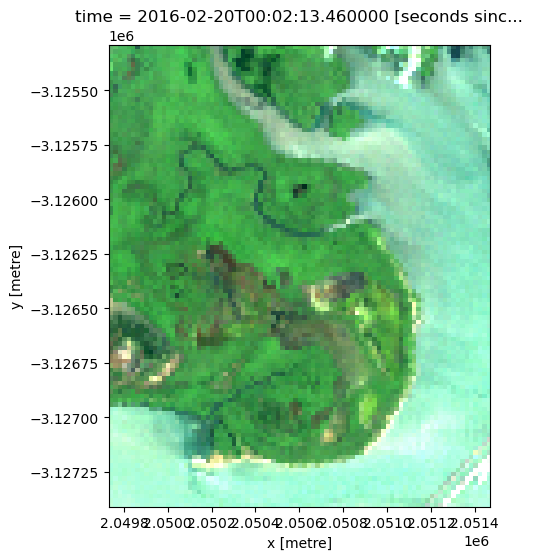

In [7]:
# Set the timesteps to visualise
timestep = 7

# Generate RGB plots at each timestep
rgb(sentinel_ds, 
    index=timestep,
    percentile_stretch=(0.00, 0.95))


## Compute Modified Normalised Difference Water Index
To extract shoreline locations, we need to be able to seperate water from land in our study area. 
To do this, we can use our Landsat data to calculate a water index called the `Modified Normalised Difference Water Index`, or MNDWI. 
This index uses the ratio of green and mid-infrared radiation to identify the presence of water [(Xu 2006)](https://www.researchgate.net/publication/232724072_Modification_of_Normalized_Difference_Water_Index_NDWI_to_Enhance_Open_Water_Features_in_Remotely_Sensed_Imagery). 
The formula is:

$$
\begin{aligned}
\text{MNDWI} &= \frac{(\text{Green} - \text{MIR})}{(\text{Green} + \text{MIR})}
\end{aligned}
$$

where `Green` is the green band and `MIR` is the mid-infrared band. 
For Landsat, we can use the Short-wave Infrared (SWIR) 1 band as our measure for `MIR`.

When it comes to interpreting the index, **High values (greater than 0, blue colours) typically represent water pixels**, while **low values (less than 0, red colours) represent land**. 
You can use the cell below to calculate and plot one of the images after calculating the index.

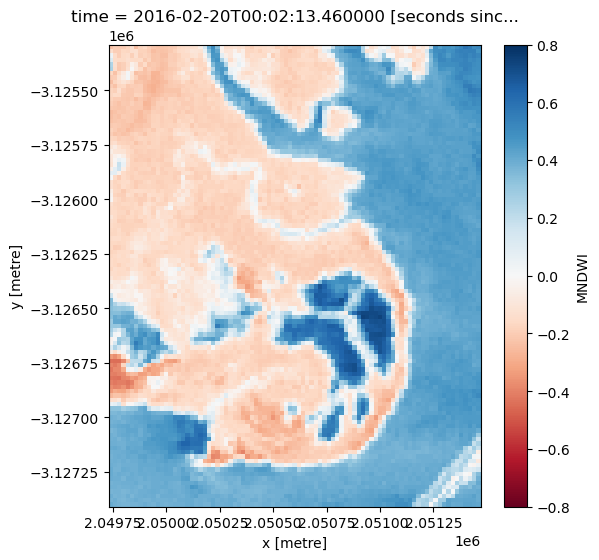

In [8]:
# Calculate the water index
sentinel_ds = calculate_indices(sentinel_ds, index='MNDWI', 
                               collection='ga_s2_3')

# Plot the resulting image for the same timestep selected above
sentinel_ds.MNDWI.isel(time=timestep).plot(cmap='RdBu',
                                          size=6,
                                          aspect=1,
                                          vmin=-0.8,
                                          vmax=0.8)


How does the plot of the index compare to the optical image from earlier? Was there water or land anywhere you weren't expecting?

## Model tide heights
The location of the shoreline can vary greatly from low to high tide. In the code below, we aim to reduce the effect of tides by modelling tide height data, and keeping only the satellite images that were taken at specific tidal conditions. For example, if `tide_range = (0.25, 0.75)`, we are telling the analysis to focus only on satellite images taken at mid-tide (e.g. when the tide was between the lowest 25th percentileand highest 75th percentile of tide heights).

The `tidal_tag` function below uses the [FES2014 tidal model](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html) to calculate the height of the tide at the exact moment each satellite image in our dataset was taken, and adds this as a new `tide_m` attribute in our dataset (for more information about this function, refer to the [Tidal modelling notebook](../How_to_guides/Tidal_modelling.ipynb)). 

> **Note:** this function can only model tides correctly if the centre of your study area is located over water. If this isn't the case, you can specify a custom tide modelling location by passing a coordinate to `tidepost_lat` and `tidepost_lon` (e.g. `tidepost_lat=-27.73, tidepost_lon=153.46`).

In [9]:
# Calculate tides for each timestep in the satellite dataset
sentinel_ds = tidal_tag(ds=sentinel_ds, tidepost_lat=-27.1725, tidepost_lon=153.0492)

# Print the output dataset with new `tide_height` variable
sentinel_ds


/tmp/ipykernel_2693/3400708592.py:2: DeprecationWarning: This function has been moved to the `eo-tides` Python package, and will be retired in a future release. Please migrate your code to use `eo-tides` instead: https://geoscienceaustralia.github.io/eo-tides/migration/
  sentinel_ds = tidal_tag(ds=sentinel_ds, tidepost_lat=-27.1725, tidepost_lon=153.0492)


Using user-supplied tide modelling location: 153.05, -27.17
Modelling tides using FES2014


<xarray.Dataset> Size: 215MB
Dimensions:       (time: 1166, y: 106, x: 87)
Coordinates:
  * time          (time) datetime64[ns] 9kB 2016-01-01T00:09:15.704000 ... 20...
  * y             (y) float64 848B -3.125e+06 -3.125e+06 ... -3.127e+06
  * x             (x) float64 696B 2.05e+06 2.05e+06 ... 2.051e+06 2.051e+06
    spatial_ref   int32 4B 3577
Data variables:
    nbart_red     (time, y, x) float32 43MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    nbart_green   (time, y, x) float32 43MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 43MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 43MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    MNDWI         (time, y, x) float32 43MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    tide_m        (time) float32 5kB 0.1712 1.244 -0.497 ... 0.4052 1.054
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

Now that we have modelled tide heights, we can plot them to visualise the range of tide that was captured by Landsat across our time series. 
In the plot below, red dashed lines also show the subset of the tidal range we selected using the `tide_range` parameter. 
The plot should make it clear that limiting the range of the tides for the analysis should give you more consistent results. 
A large variance in the tide height could obscure your results, so consistency is critical as you want to compare the change in the shoreline from year to year.

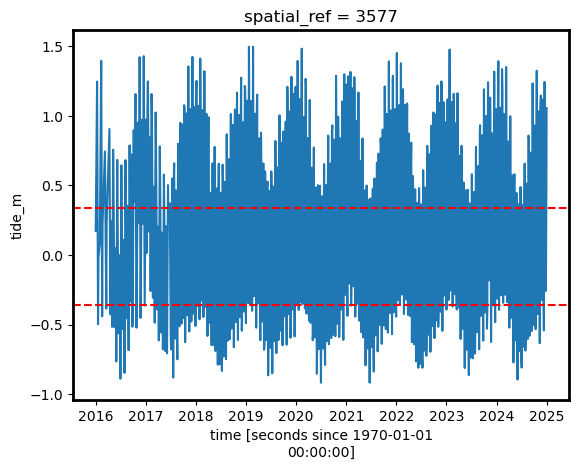

In [10]:
# Calculate the min and max tide heights to include based on the % range
min_tide, max_tide = sentinel_ds.tide_m.quantile(tide_range) 

# Plot the resulting tide heights for each Landsat image:
sentinel_ds.tide_m.plot()
plt.axhline(min_tide, c='red', linestyle='--')
plt.axhline(max_tide, c='red', linestyle='--')


### Filter Landsat images by tide height
Here we take the Landsat dataset and only keep the images with tide heights we want to analyse (i.e. tides within the heights given by `tide_range`). This will result in a smaller number of images (e.g. ~400 images compared to ~900):

In [11]:
# Keep timesteps larger than the min tide, and smaller than the max tide
sentinel_filtered = sentinel_ds.sel(time=(sentinel_ds.tide_m > min_tide) &
                                       (sentinel_ds.tide_m <= max_tide))
sentinel_filtered

<xarray.Dataset> Size: 75MB
Dimensions:       (time: 408, y: 106, x: 87)
Coordinates:
  * time          (time) datetime64[ns] 3kB 2016-01-01T00:09:15.704000 ... 20...
  * y             (y) float64 848B -3.125e+06 -3.125e+06 ... -3.127e+06
  * x             (x) float64 696B 2.05e+06 2.05e+06 ... 2.051e+06 2.051e+06
    spatial_ref   int32 4B 3577
Data variables:
    nbart_red     (time, y, x) float32 15MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    nbart_green   (time, y, x) float32 15MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 15MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 15MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    MNDWI         (time, y, x) float32 15MB dask.array<chunksize=(1, 106, 87), meta=np.ndarray>
    tide_m        (time) float32 2kB 0.1712 -0.01564 0.08096 ... -0.259 -0.2244
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [12]:
#combine into non-calendar annual geomedians around 30 March (Debbie)

In [13]:
# Shift time back by 3 months, so "year" starts in April
import pandas as pd
import xarray as xr

def annual_medians_april_march(da, variable='MNDWI'):
    """
    Resamples an xarray DataArray by April–March years and returns median values with custom labels.
    
    Parameters:
    - da: xarray.DataArray containing a 'time' dimension
    - variable: string name of the variable to process (if a Dataset is passed)
    
    Returns:
    - xarray.DataArray with annual medians and custom 'year_label' coordinate
    """
    # If a Dataset is passed, select the variable (e.g., 'MNDWI')
    if isinstance(da, xr.Dataset):
        da = da['MNDWI']

    # Step 1: Shift time back by 3 months (to align April–March)
    shifted_time = pd.to_datetime(da.time.values) - pd.DateOffset(months=3)
    shifted = da.assign_coords(time=xr.DataArray(shifted_time, dims="time"))

    # Step 2: Resample by calendar year (now effectively April–March), compute median
    annual_medians = shifted.resample(time='1Y').median('time')

    # Step 3: Shift time labels forward 3 months (back to April)
    corrected_time = pd.to_datetime(annual_medians.time.values) + pd.DateOffset(months=3)
    annual_medians = annual_medians.assign_coords(time=xr.DataArray(corrected_time, dims="time"))

    # Step 4: Add custom label like '04/2016–17'
    custom_labels = [
        f"04/{t.year-1}-{str((t.year) % 100).zfill(2)}"
        for t in corrected_time
    ]
    annual_medians = annual_medians.assign_coords(year_label=("time", custom_labels))

    return annual_medians



In [14]:
#mask is being applied by year rather than globally to all years.
import pandas as pd

# Create a new "year_label" that reflects the April–March grouping
year_labels = (
    sentinel_filtered["time"].dt.year - (sentinel_filtered["time"].dt.month < 4)
)

# Loop through each unique April–March year
filtered_annual_data = {}

for year in year_labels.values:
    # Select data corresponding to this April–March period
    yearly_data = sentinel_filtered.sel(
        time=(year_labels == year)
    )

    # Compute count of non-NaN values per pixel
    valid_counts = yearly_data["MNDWI"].count(dim="time")

    # Compute standard deviation per pixel
    std_dev = yearly_data["MNDWI"].std(dim="time")

    # Apply a distinct mask for each April–March period
    valid_mask = (valid_counts >= 5) & (std_dev <= 0.5)

    # Store the filtered data for this period
    filtered_annual_data[year] = yearly_data["MNDWI"].where(valid_mask)

# Convert dictionary to an xarray dataset
filtered_data = xr.concat(filtered_annual_data.values(), dim="time")

# Compute annual medians for April–March periods
sentinel_summaries = annual_medians_april_march(filtered_data)


/env/lib/python3.10/site-packages/xarray/groupers.py:403: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [15]:
# Inspect the min, max, and mean values of the original MNDWI data
print(sentinel_summaries.min().values)  # Check the min value
print(sentinel_summaries.max().values)  # Check the max value
print(sentinel_summaries.mean().values)  # Check the mean value

/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


-0.56577754
0.91902834
0.15700577


In [16]:
print(sentinel_filtered.coords)

Coordinates:
  * time         (time) datetime64[ns] 3kB 2016-01-01T00:09:15.704000 ... 202...
  * y            (y) float64 848B -3.125e+06 -3.125e+06 ... -3.127e+06
  * x            (x) float64 696B 2.05e+06 2.05e+06 ... 2.051e+06 2.051e+06
    spatial_ref  int32 4B 3577


In [17]:
import pandas as pd 
# Convert 'time' to datetime format if not already 
sentinel_filtered["time"] = pd.to_datetime(sentinel_filtered["time"]) 
# Assign April-March year dynamically 
april_march_year = sentinel_filtered["time"].dt.year.where(sentinel_filtered["time"].dt.month >= 4, sentinel_filtered["time"].dt.year - 1)


In [18]:
#print(filtered_time_step_df.columns)

In [19]:
# Apply validity mask before counting time-steps
filtered_pixel_time_counts = sentinel_filtered["MNDWI"].where(valid_mask).groupby(april_march_year).count(dim="time")

# Compute mean across spatial dimensions
mean_time_steps_per_year_filtered = filtered_pixel_time_counts.mean(dim=["x", "y"])

# Convert to DataFrame for readability
filtered_time_step_df = mean_time_steps_per_year_filtered.to_dataframe(name="Mean Images Per Year").reset_index()

# Rename the year column for clarity
#filtered_time_step_df.rename(columns={"april_march_year": "April-March Year"}, inplace=True)

# Print the table
print(filtered_time_step_df)

# Number of time periods with data
num_plots = len(sentinel_summaries['time'])



   year  spatial_ref  Mean Images Per Year
0  2015         3577              2.946866
1  2016         3577             14.140642
2  2017         3577             25.747669
3  2018         3577             30.359358
4  2019         3577             34.162980
5  2020         3577             31.646064
6  2021         3577             23.549664
7  2022         3577             37.071676
8  2023         3577             30.627196
9  2024         3577             31.629581


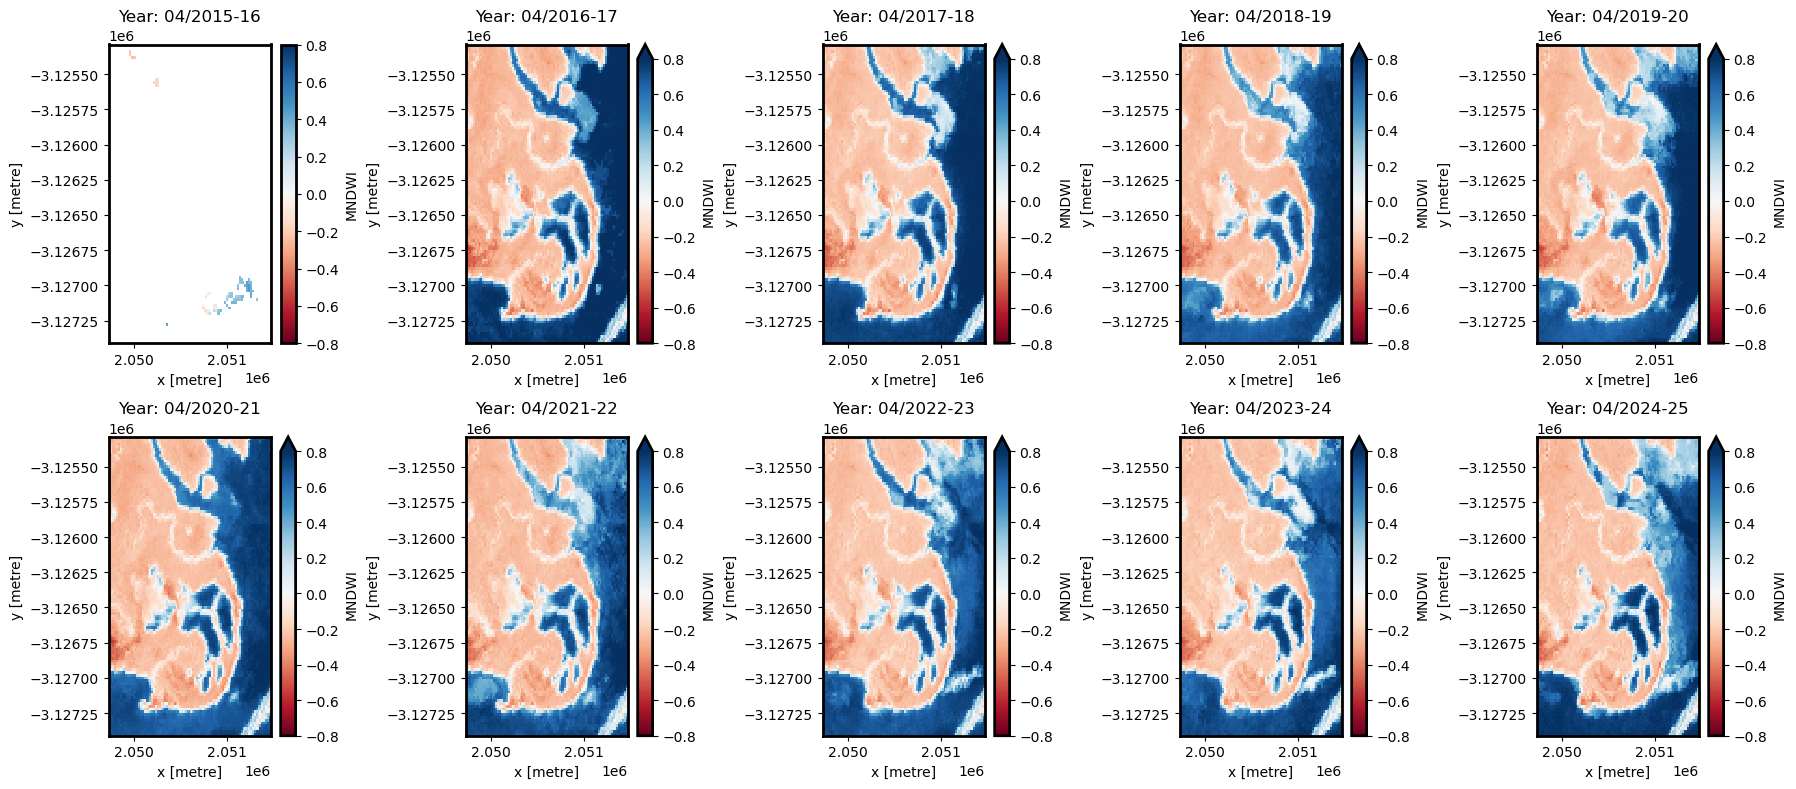

In [20]:
# Set up figure grid
cols = 5
rows = (num_plots + cols - 1) // cols  # This ensures rounding up
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, rows * 4))
axes = axes.flatten()

# Loop through each time period and plot
for i, time_period in enumerate(sentinel_summaries['time'].values):
    ax = axes[i]
    data_slice = sentinel_summaries.sel(time=time_period)
    data_slice.plot(ax=ax, cmap='RdBu', vmin=-0.8, vmax=0.8)
    ax.set_title(f"Year: {sentinel_summaries.year_label.values[i]}")

# Remove any unused axes
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])  # Deletes the unused subplot

# Final layout adjustment
plt.tight_layout()
plt.show()

Loading data into memory using Dask
Operating in single z-value, multiple arrays mode
Failed to generate contours: 2016-03-31
Writing contours to output_waterlines_sentinel.geojson


<Axes: title={'center': 'spatial_ref = 3577, time = 2024-03-31, year_lab...'}, xlabel='x [metre]', ylabel='y [metre]'>

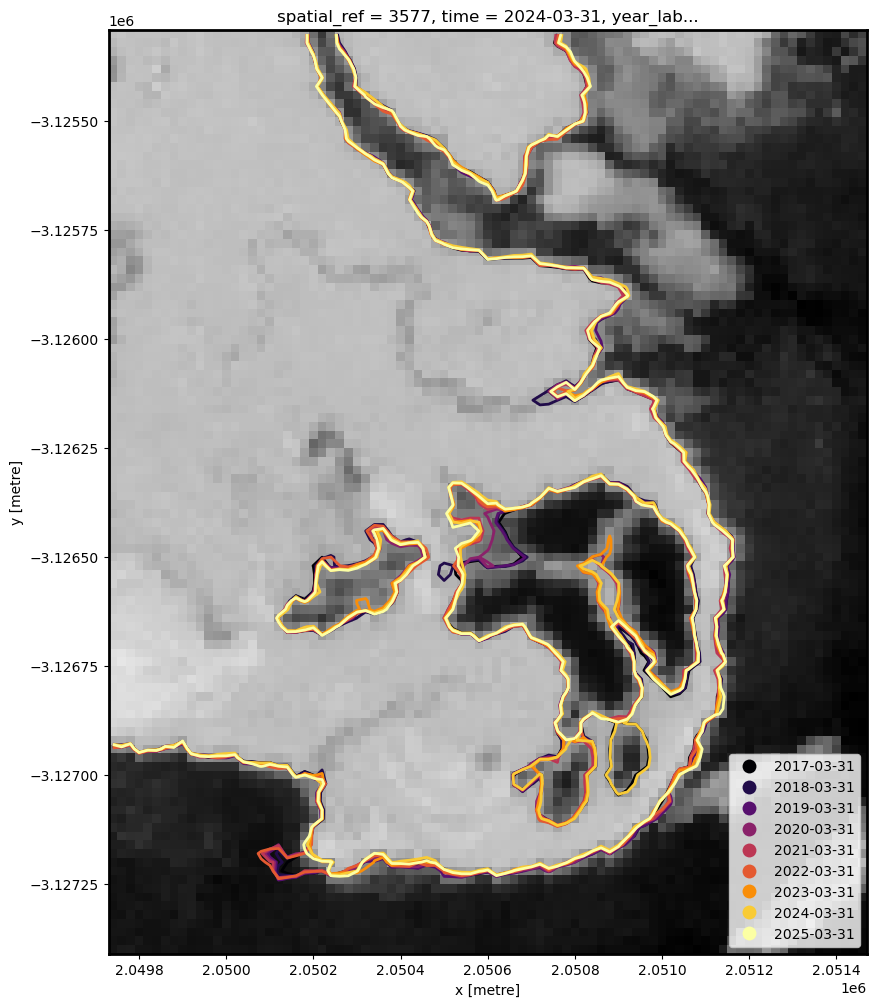

In [21]:
# Extract waterlines
contours_gdf = subpixel_contours(da=sentinel_summaries,
                                 z_values=0,
                                 output_path=f'output_waterlines_sentinel.geojson',
                                 min_vertices=50)

# Plot output shapefile over the first MNDWI layer in the time series
sentinel_summaries.isel(time=8).plot(size=12, 
                                    cmap='Greys', 
                                    add_colorbar=False)
contours_gdf.plot(ax=plt.gca(), 
                  column='time',
                  cmap='inferno',
                  linewidth=2,
                  legend=True,
                  legend_kwds={'loc': 'lower right'})


<Axes: >

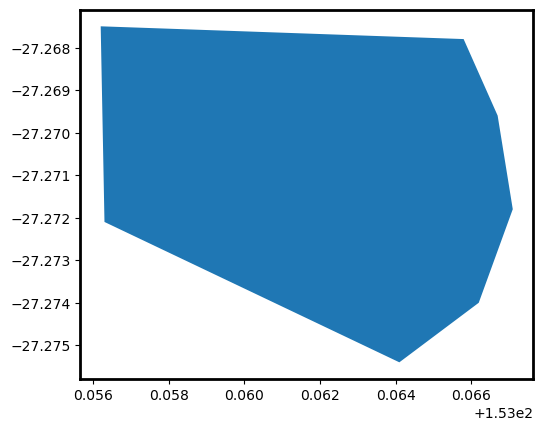

In [22]:
import geopandas as gpd
import numpy as np
import xarray as xr

from shapely.geometry import Polygon

#Remove polygon with internal water bodies
# Define the coordinates in (longitude, latitude) order
coords = [
    (153.0562, -27.2675),  # Longitude, Latitude
    (153.0658, -27.2678),
    (153.0667, -27.2696),
    (153.0671, -27.2718),
    (153.0662, -27.2740),
    (153.0641, -27.2754),
    (153.0563, -27.2721),
    (153.0562, -27.2675)   # Closing the polygon
]

# Create a Polygon object using Shapely with the corrected coordinates
polygon = Polygon(coords)

# Create a GeoDataFrame with the polygon in EPSG:4326 (WGS84)
gdf_polygon = gpd.GeoDataFrame({'geometry': [polygon]}, crs="EPSG:4326")

# Plot the corrected polygon
gdf_polygon.plot()


<Axes: >

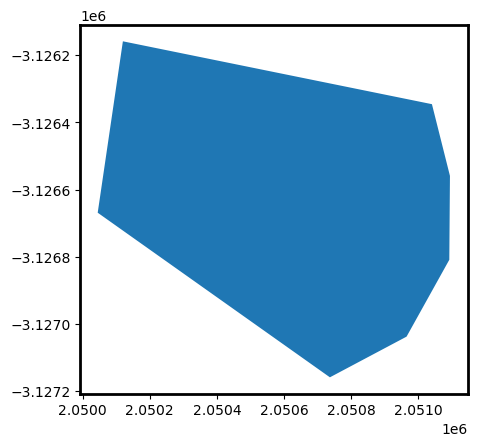

In [23]:
# Reproject the polygon to EPSG:3577 (Australian Coordinate System)
gdf_polygon = gdf_polygon.to_crs("EPSG:3577")

# Check the reprojected polygon in EPSG:3577
gdf_polygon.plot()


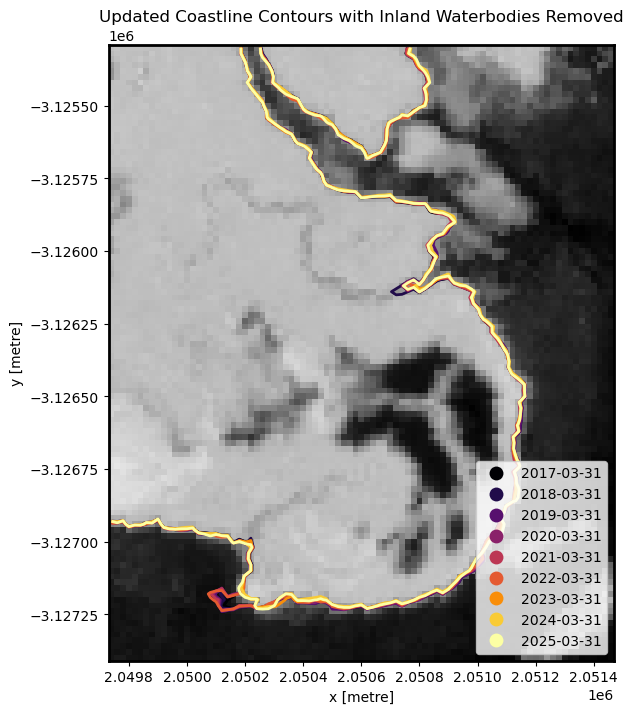

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Ensure both GeoDataFrames have the same CRS
contours_gdf = contours_gdf.to_crs(gdf_polygon.crs)

# Remove contours inside the polygon
updated_contours_gdf = gpd.overlay(contours_gdf, gdf_polygon, how='difference')

# Plot the updated contours
fig, ax = plt.subplots(figsize=(12, 8))

# Base raster plot
sentinel_summaries.isel(time=8).plot(ax=ax, cmap='Greys', add_colorbar=False)

# Updated contours
updated_contours_gdf.plot(ax=ax, column='time', cmap='inferno', linewidth=2, 
                          legend=True, legend_kwds={'loc': 'lower right'})

plt.title("Updated Coastline Contours with Inland Waterbodies Removed")
plt.show()


## Combine observations into noise-free summary images
Individual remote sensing images can be affected by noisy data, including clouds, sunglint and poor water quality conditions (e.g. sediment). To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. In this case, we use the median as the summary statistic because it prevents strong outliers (like masked cloud values) from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '2Y'`, the code will produce one new image for each two-year period in the dataset. This step can take **several minutes to load** if the study area is large.

## Extract shorelines from imagery
We now want to extract an accurate shoreline for each each of the summary images above (e.g. 2000, 2001 etc. summaries). 
The code below identifies the boundary between land and water by tracing a line along pixels with a water index value of `0` (halfway between land and water water index values). 
It returns a `geopandas.GeoDataFrame` with one line feature for each time step:


The above plot is a basic visualisation of the contours returned by the `subpixel_contours` function. 
Given we now have the shapefile, we can use a more complex function to make an interactive plot for viewing the change in shoreline over time below.

### Plot interactive map of output shorelines coloured by time
The next cell provides an interactive map with an overlay of the shorelines identified in the previous cell. 
Run it to view the map.

Zoom in to the map below to explore the resulting set of shorelines. 
Older shorelines are coloured in yellow, and more recent shorelines in red.
Hover over the lines to see the time period for each shoreline printed above the map.
Using this data, we can easily identify areas of coastline or rivers that have changed significantly over time, or areas that have remained stable over the entire time period. 


In [25]:
# Convert 'time' to datetime format
updated_contours_gdf['time'] = pd.to_datetime(updated_contours_gdf['time'])

# Convert 'time' column to string BEFORE filtering
updated_contours_gdf['time'] = updated_contours_gdf['time'].astype(str)

# Extract only the year and filter for 2017, 2018, and 2023
years_to_plot = [2017, 2018, 2023]
filtered_contours_gdf = updated_contours_gdf[updated_contours_gdf['time'].str[:4].isin(map(str, years_to_plot))]

# Plot the filtered contours on an interactive map
filtered_contours_gdf.explore(column='time', cmap='inferno', categorical=True)


In [26]:
filtered_contours_4326_gdf = filtered_contours_gdf.to_crs("EPSG:4326")


In [27]:

import folium

# Define a color mapping for different years
year_colors = {
   "2017": "#D3D3D3",  # Light Gray
    "2018": "#ff0000",  # Red
    "2023": "#ffff00",  # Yellow
}

# Function to style each year differently
def style_function(feature):
    year = feature["properties"]["time"][:4]  # Extract the year as a string
    return {
        'color': year_colors.get(year, "#888888"),  # Default gray if year is missing
        'weight': 3,  # Line thickness
        'opacity': 0.9,  # Transparency
    }

# Create Folium map centered on dataset
m = folium.Map(
    location=[filtered_contours_4326_gdf.geometry.centroid.y.mean(), 
              filtered_contours_4326_gdf.geometry.centroid.x.mean()],
    zoom_start=15,
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="ESRI World Imagery", control_scale=True
)

# Add contours with dynamic colors
folium.GeoJson(
    data=filtered_contours_4326_gdf.to_json(),
    name="Landsat Contours",
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=["time"], labels=True),  # Adds tooltips showing the year
).add_to(m)

# Add Layer Control to toggle visibility
folium.LayerControl().add_to(m)

# Show the map
m


/tmp/ipykernel_2693/4259410658.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[filtered_contours_4326_gdf.geometry.centroid.y.mean(),
/tmp/ipykernel_2693/4259410658.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  filtered_contours_4326_gdf.geometry.centroid.x.mean()],


In [28]:
import pyproj
from shapely.ops import nearest_points
from pyproj import Geod
from scipy.stats import circstd, circmean, linregress

baseline_year = 2023
water_index = "MNDWI"

In [29]:
#Generating distance data and stats

In [30]:
import pandas as pd

# Ensure 'time' is in datetime format
updated_contours_gdf["time"] = pd.to_datetime(updated_contours_gdf["time"], errors="coerce")

# Extract year from 'time' column
updated_contours_gdf["year"] = updated_contours_gdf["time"].dt.year

# Set 'year' as the index
updated_contours_gdf.set_index("year", inplace=True)

# Verify corrected index
print(updated_contours_gdf.index.unique())  # Should show actual years like 2016, 2017, 2018, etc.


Index([2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025], dtype='int32', name='year')


In [31]:
import geopandas as gpd

# Select the 2023 coastline
baseline_year = 2023
baseline_contour = updated_contours_gdf.loc[baseline_year].geometry

# Function to generate points along the line at 30m intervals
def points_on_line(line_geometry, distance=30):
    """
    Generates evenly spaced points along a line geometry.
    """
    points_line = [line_geometry.interpolate(i) for i in range(0, int(line_geometry.length), distance)]
    points_gdf = gpd.GeoDataFrame(geometry=points_line, crs=updated_contours_gdf.crs)
    return points_gdf

# Apply function to create points along the 2023 contour
points_gdf = points_on_line(baseline_contour, distance=30)


In [32]:
print(points_gdf.head())  # Should display the first few points
print(len(points_gdf))  # Total number of points generated


                           geometry
0  POINT (2049740.000 -3126931.418)
1  POINT (2049769.797 -3126930.443)
2  POINT (2049793.107 -3126942.922)
3  POINT (2049820.572 -3126942.920)
4  POINT (2049850.297 -3126940.602)
182


In [33]:
print(sentinel_summaries.name)  # Should display the variable name ('MNDWI' if correct)
print(sentinel_summaries.dims)  # Shows available dimensions
print(sentinel_summaries.coords)  # Lists coordinate names like 'time'


MNDWI
('time', 'y', 'x')
Coordinates:
  * y            (y) float64 848B -3.125e+06 -3.125e+06 ... -3.127e+06
  * x            (x) float64 696B 2.05e+06 2.05e+06 ... 2.051e+06 2.051e+06
    spatial_ref  int32 4B 3577
  * time         (time) datetime64[ns] 80B 2016-03-31 2017-03-31 ... 2025-03-31
    year_label   (time) <U10 400B '04/2015-16' '04/2016-17' ... '04/2024-25'


In [34]:
print(sentinel_summaries.time.values)

['2016-03-31T00:00:00.000000000' '2017-03-31T00:00:00.000000000'
 '2018-03-31T00:00:00.000000000' '2019-03-31T00:00:00.000000000'
 '2020-03-31T00:00:00.000000000' '2021-03-31T00:00:00.000000000'
 '2022-03-31T00:00:00.000000000' '2023-03-31T00:00:00.000000000'
 '2024-03-31T00:00:00.000000000' '2025-03-31T00:00:00.000000000']


In [35]:
print(sentinel_summaries.sel(time="2023-03-31"))

<xarray.DataArray 'MNDWI' (y: 106, x: 87)> Size: 37kB
dask.array<getitem, shape=(106, 87), dtype=float32, chunksize=(106, 87), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 848B -3.125e+06 -3.125e+06 ... -3.127e+06
  * x            (x) float64 696B 2.05e+06 2.05e+06 ... 2.051e+06 2.051e+06
    spatial_ref  int32 4B 3577
    time         datetime64[ns] 8B 2023-03-31
    year_label   <U10 40B '04/2022-23'


In [36]:


def annual_movements(
    points_gdf, updated_contours_gdf, sentinel_summaries, baseline_year, water_index, max_valid_dist=30
):
    """
    Computes distances and directions of coastline movement for 2017 and 2018 relative to baseline 2023.
    """

    def _point_interp(points, array, **kwargs):
        points_gs = gpd.GeoSeries(points)
        x_vals = xr.DataArray(points_gs.x, dims="z")
        y_vals = xr.DataArray(points_gs.y, dims="z")
        return array.interp(x=x_vals, y=y_vals, **kwargs)

    baseline_array = sentinel_summaries.sel(time=f"{baseline_year}-03-31")


    # Copy baseline point geometry
    points_gdf["p_baseline"] = points_gdf.geometry

    # **Only process 2017 & 2018**
    comparison_years = [2017, 2018]

    for comp_year in comparison_years:
        # Retrieve comparison contour for the given year
        comp_contour = updated_contours_gdf.loc[[comp_year]].geometry.iloc[0]

        # Find nearest point on comparison contour
        points_gdf[f"p_{comp_year}"] = points_gdf.apply(
            lambda x: nearest_points(x.p_baseline, comp_contour)[1], axis=1
        )

        # Compute distance and ensure values beyond threshold are NaN
        distances = points_gdf.apply(
            lambda x: x.geometry.distance(x[f"p_{comp_year}"]), axis=1
        )
        points_gdf[f"dist_{comp_year}"] = distances.where(distances < max_valid_dist)

        # Extract comparison year’s water index values
        comp_array = sentinel_summaries.sel(time=pd.to_datetime(f"{comp_year}-03-31"))

        # Sample water index values
        points_gdf["index_comp_p1"] = _point_interp(points_gdf.geometry, comp_array)
        points_gdf["index_baseline_p2"] = _point_interp(points_gdf[f"p_{comp_year}"], baseline_array)

        # Compute inland vs sea-ward movement
        points_gdf["loss_gain"] = np.where(
            points_gdf.index_baseline_p2 > points_gdf.index_comp_p1, 1, -1
        )
        is_nan = points_gdf[["index_comp_p1", "index_baseline_p2"]].isna().any(axis=1)
        points_gdf["loss_gain"] = points_gdf["loss_gain"].where(~is_nan)

        # Apply directional sign to distances
        points_gdf[f"dist_{comp_year}"] = points_gdf[f"dist_{comp_year}"] * points_gdf.loss_gain

        # Compute compass bearings
        lat_lon = points_gdf[["p_baseline", f"p_{comp_year}"]].apply(
            lambda x: gpd.GeoSeries(x, crs=points_gdf.crs).to_crs("EPSG:4326")
        )
        geodesic = pyproj.Geod(ellps="WGS84")
        bearings = geodesic.inv(
            lons1=lat_lon.iloc[:, 0].values.x,
            lats1=lat_lon.iloc[:, 0].values.y,
            lons2=lat_lon.iloc[:, 1].values.x,
            lats2=lat_lon.iloc[:, 1].values.y,
        )[0]

        # Restrict angles to 0-180 for overall directional analysis
        points_gdf[f"bearings_{comp_year}"] = bearings % 180

    # Compute summary statistics for bearings
    points_gdf["angle_mean"] = (
        points_gdf.loc[:, points_gdf.columns.str.contains("bearings_")]
        .apply(lambda x: circmean(x, high=180), axis=1)
        .round(0)
        .astype(int)
    )
    points_gdf["angle_std"] = (
        points_gdf.loc[:, points_gdf.columns.str.contains("bearings_")]
        .apply(lambda x: circstd(x, high=180), axis=1)
        .round(0)
        .astype(int)
    )

    # Keep only required columns
    to_keep = points_gdf.columns.str.contains("dist|geometry|angle")
    points_gdf = points_gdf.loc[:, to_keep]
    points_gdf = points_gdf.assign(**{f"dist_{baseline_year}": 0.0})
    points_gdf = points_gdf.round(2)

    return points_gdf


In [37]:
print(points_gdf.head())  # Check if key columns (geometry, distances) exist
print(points_gdf.columns)  # Ensure columns like dist_2017, dist_2018 are present


                           geometry
0  POINT (2049740.000 -3126931.418)
1  POINT (2049769.797 -3126930.443)
2  POINT (2049793.107 -3126942.922)
3  POINT (2049820.572 -3126942.920)
4  POINT (2049850.297 -3126940.602)
Index(['geometry'], dtype='object')


In [38]:
print(annual_movements(points_gdf, updated_contours_gdf, sentinel_summaries, baseline_year, water_index))


                             geometry  dist_2017  dist_2018  angle_mean  \
0    POINT (2049740.000 -3126931.418)       2.62      -2.01         172   
1    POINT (2049769.797 -3126930.443)       2.56      -1.13         159   
2    POINT (2049793.107 -3126942.922)       0.52      -0.52          27   
3    POINT (2049820.572 -3126942.920)       1.50      -0.07         170   
4    POINT (2049850.297 -3126940.602)       1.09      -1.93         149   
..                                ...        ...        ...         ...   
177  POINT (2050833.467 -3125417.917)      -6.26      -5.56          70   
178  POINT (2050823.844 -3125389.528)      -4.47      -3.01          54   
179  POINT (2050802.989 -3125370.071)      -4.08      -2.64          25   
180  POINT (2050786.334 -3125345.657)      -2.54      -1.63          54   
181  POINT (2050767.251 -3125323.700)      -6.96      -5.33          22   

     angle_std  dist_2023  
0            2        0.0  
1            3        0.0  
2            1 

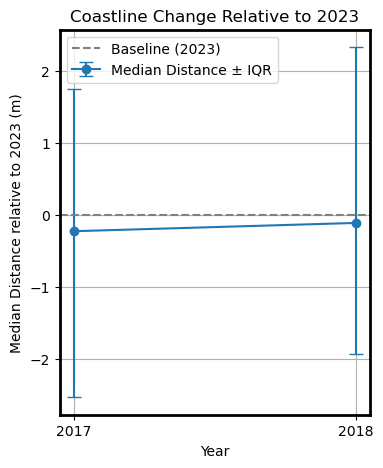

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import matplotlib.ticker as mticker


# Extract the relevant distance columns
distance_cols = [col for col in points_gdf.columns if col.startswith("dist_")]

# Convert to DataFrame for easier manipulation
distance_df = points_gdf[distance_cols].melt(var_name="Year", value_name="Signed Distance")

# Clean up year column (removing 'dist_' prefix)
distance_df["Year"] = distance_df["Year"].str.replace("dist_", "").astype(int)

# Compute median signed distance per year (Q2)
median_dist = distance_df.groupby("Year")["Signed Distance"].median()

# Compute IQR (Interquartile Range)
q1 = distance_df.groupby("Year")["Signed Distance"].quantile(0.25)
q3 = distance_df.groupby("Year")["Signed Distance"].quantile(0.75)
iqr_error = np.vstack([median_dist - q1, q3 - median_dist])  # Upper and lower error bars


# **Plot**
plt.figure(figsize=(4, 5))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))  # Forces yearly spacing
plt.errorbar(median_dist.index, median_dist, yerr=iqr_error, fmt="o-", capsize=5, label="Median Distance ± IQR")
plt.axhline(0, color="gray", linestyle="--", label="Baseline (2023)")

plt.xlabel("Year")
plt.ylabel("Median Distance relative to 2023 (m)")
plt.title("Coastline Change Relative to 2023")
plt.xticks(median_dist.index)  # Ensure year is treated as discrete integers
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [40]:
print(distance_df["Signed Distance"].isna().sum())  # Count NaNs
print(distance_df["Signed Distance"].describe())  # Check data summary


0
count    364.000000
mean       0.037166
std        4.773878
min      -14.869679
25%       -2.098143
50%       -0.186706
75%        1.993427
max       28.557804
Name: Signed Distance, dtype: float64


In [41]:
print(distance_df.groupby("Year")["Signed Distance"].count())  # Count entries per year


Year
2017    182
2018    182
Name: Signed Distance, dtype: int64


In [42]:
print(distance_df["Year"].dtype)


int64


In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

# Extract the relevant distance columns
distance_cols = [col for col in points_gdf.columns if col.startswith("dist_")]

# Convert to DataFrame for easier manipulation
distance_df = points_gdf[distance_cols].melt(var_name="Year", value_name="Signed Distance")

# Clean up year column (removing 'dist_' prefix)
distance_df["Year"] = distance_df["Year"].str.replace("dist_", "").astype(int)

distance_df = distance_df.dropna(subset=["Year", "Signed Distance"])

# **Perform linear regression on ALL individual signed distance values**
slope, intercept, r_value, p_value, std_err = linregress(distance_df["Year"], distance_df["Signed Distance"])

# Compute coefficient of determination (R-squared)
r_squared = r_value**2

# Print full regression statistics
print(f"Slope: {slope:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Standard Error of Slope: {std_err:.4f}")

# **Interpret significance of the slope**
if p_value < 0.05:
    print("The slope is significantly different from zero (p < 0.05), indicating a likely trend.")
else:
    print("The slope is NOT significantly different from zero (p ≥ 0.05), suggesting no clear trend.")



Slope: 0.7125
R-squared: 0.0056
P-value: 0.1548
Standard Error of Slope: 0.4997
The slope is NOT significantly different from zero (p ≥ 0.05), suggesting no clear trend.


## Next steps
When you are done, return to the "Set up analysis" cell, modify some values (e.g. `time_range`, `tide_range`, `time_step` or `lat_range`/`lon_range`) and rerun the analysis. For example, to run the same analysis on the Gold Coast/Tweed Head beaches near the NSW/Queensland border, you could try the following values:
```
lat_range = (-28.16, -28.18)
lon_range = (153.52, 153.56) 
time_range = ('1988', '2018') 
time_step = '2Y'
tide_range = (0.50, 1.00)
```
Or to analyse an erosion hotspot at Pinnaroo Point in Perth, WA:
```
lat_range = (-31.795, -31.835)
lon_range = (115.72, 115.75) 
time_range = ('1988', '2018') 
time_step = '2Y'
tide_range = (0.50, 1.00)
```

If you change the location, you'll need to make sure Landsat 5, 7 and 8 data is available for the new location, which you can check at the [DEA Explorer](https://explorer.dea.ga.gov.au/ga_ls5t_ard_3/1990) (use the drop-down menu to view all Landsat products). 

### Digital Earth Australia Coastlines

The Digital Earth Australia Coastlines product is a continental dataset providing annual shorelines and rates of change along the entire Australian coastline from 1988 to the present.
To explore this dataset:
* Run the [DEA Coastlines notebook](../DEA_products/DEA_Coastlines.ipynb) 
* Explore the dataset on the [interactive DEA Maps platform](https://maps.dea.ga.gov.au/#share=s-DEACoastlines&playStory=1).
* Read the scientific paper:

> Bishop-Taylor, R., Nanson, R., Sagar, S., Lymburner, L. (2021). Mapping Australia's dynamic coastline at mean sea level using three decades of Landsat imagery. *Remote Sensing of Environment* 267, 112734. Available: https://doi.org/10.1016/j.rse.2021.112734

![Test](https://data.dea.ga.gov.au/projects/coastlines/deacoastlines_anim_streakybay.gif)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2023

**Compatible datacube version:** 

In [44]:
print(datacube.__version__)

1.8.19


## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://knowledge.dea.ga.gov.au/genindex/) -->

In [45]:
points_gdf = points_gdf.to_crs("EPSG:4326")
filtered_contours_gdf = filtered_contours_gdf.to_crs("EPSG:4326")

print(points_gdf.geometry.head())  # Check the actual geometry column
print(points_gdf.geometry.x.head())  # Should return longitude values
print(points_gdf.geometry.y.head())  # Should return latitude values

0    POINT (153.05367 -27.27485)
1    POINT (153.05397 -27.27480)
2    POINT (153.05422 -27.27488)
3    POINT (153.05450 -27.27484)
4    POINT (153.05479 -27.27477)
Name: geometry, dtype: geometry
0    153.053666
1    153.053965
2    153.054221
3    153.054498
4    153.054794
dtype: float64
0   -27.274853
1   -27.274800
2   -27.274876
3   -27.274836
4   -27.274772
dtype: float64


In [46]:
# Convert 'time' to datetime format
updated_contours_gdf['time'] = pd.to_datetime(updated_contours_gdf['time'])

# Convert 'time' column to string BEFORE filtering
updated_contours_gdf['time'] = updated_contours_gdf['time'].astype(str)

# Extract only the year and filter for 2017, 2018, and 2023
years_to_plot = [2017, 2018, 2022, 2023]
filtered_contours_gdf = updated_contours_gdf[updated_contours_gdf['time'].str[:4].isin(map(str, years_to_plot))]

# Create the base map from contours
m = filtered_contours_gdf.explore(column='time', cmap='inferno', categorical=True)

In [47]:
import folium

# Add point markers to the map
for _, row in points_gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],  # Extract lat/lon from geometry
        popup=f"Point ({row.geometry.x:.6f}, {row.geometry.y:.6f})",
        icon=folium.Icon(color="blue", icon="info-sign"),
    ).add_to(m)

# Display the final map with both contours and points
m


In [48]:
print(points_gdf)

                        geometry                        p_baseline  \
0    POINT (153.05367 -27.27485)  POINT (2049740.000 -3126931.418)   
1    POINT (153.05397 -27.27480)  POINT (2049769.797 -3126930.443)   
2    POINT (153.05422 -27.27488)  POINT (2049793.107 -3126942.922)   
3    POINT (153.05450 -27.27484)  POINT (2049820.572 -3126942.920)   
4    POINT (153.05479 -27.27477)  POINT (2049850.297 -3126940.602)   
..                           ...                               ...   
177  POINT (153.06216 -27.25994)  POINT (2050833.467 -3125417.917)   
178  POINT (153.06201 -27.25971)  POINT (2050823.844 -3125389.528)   
179  POINT (153.06177 -27.25957)  POINT (2050802.989 -3125370.071)   
180  POINT (153.06156 -27.25938)  POINT (2050786.334 -3125345.657)   
181  POINT (153.06133 -27.25921)  POINT (2050767.251 -3125323.700)   

                               p_2017  dist_2017  index_comp_p1  \
0    POINT (2049740.000 -3126934.037)   2.618085       0.030728   
1    POINT (2049770.416 -

In [49]:
# Save the GeoDataFrame as a GeoJSON file
import geopandas as gpd

# Load the original GeoDataFrame (assuming it's already created)
s2023_points_gdf = points_gdf[['geometry', 'dist_2017', 'dist_2018']]

# Save to a GeoJSON file
s2023_points_gdf.to_file("sentinel2023_points.geojson", driver="GeoJSON")

print("GeoJSON file saved successfully.")


GeoJSON file saved successfully.


In [50]:
s2017_points_gdf = points_gdf[['p_2017', 'dist_2017', 'dist_2018']].copy()

# Ensure 'p_2017' is set as the geometry column
s2017_points_gdf = s2017_points_gdf.set_geometry("p_2017")

# Set the CRS explicitly
s2017_points_gdf.set_crs("EPSG:3577", inplace=True)

# Verify the CRS is now assigned
print(s2017_points_gdf.crs)  # Should return 'EPSG:3577'

# Try saving the GeoJSON file again
s2017_points_gdf.to_file("sentinel2017_points.geojson", driver="GeoJSON")
print("GeoJSON file saved successfully.")


EPSG:3577
GeoJSON file saved successfully.
